In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np 
from numpy import log
import gmaps 
import gmaps.datasets 
import matplotlib.pyplot as plt
import matplotlib.pyplot as set_ylim
from datetime import datetime
import shap
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

<h4>Load data</h4>

In [35]:
# import predictions data for use in the carbon zero simulation
y_hat_pred = pd.read_csv('stationary-data/y_hat_pred.csv')

In [24]:
# read in X_train data
X_train = pd.read_csv('stationary-data/X_train.csv')

In [29]:
# read in X_train data
y_train = pd.read_csv('stationary-data/y_train.csv')

In [9]:
# join predictions with X_train 
resid_df = X_train

In [28]:
resid_df['code_release_act'] = y_train['code_release']

In [34]:
resid_df['code_release_pred'] = y_hat_pred['0']

In [52]:
len(kwh_year_df['Parcel Number'].unique())

8635

In [53]:
kwh_year_df = kwh_year_df.drop_duplicates(subset=['Parcel Number'])

In [54]:
kwh_year_df = kwh_year_df.set_index('Parcel Number')

In [55]:
preds_electricity_df = index_pred_df.join(kwh_year_df, how="left", on='Parcel Number', lsuffix='_left', rsuffix='_right')
# electricity_df['preds'] = preds_electricity_df['preds']


In [15]:
# preds_electricity_df = preds_electricity_df.drop(columns='Unnamed: 0')

In [18]:
# preds_electricity_df = preds_electricity_df.reset_index()

<h4>How different are the predicted efficiency indexe from the code releases?</h4>

In [38]:
# address = electricity_df[['Service Address', 'preds']].groupby('Service Address')['preds'].agg('count')


In [74]:
# address_df = address.to_frame()

In [13]:
# address_df = address_df.reset_index()

In [75]:
# address_df.info()

In [76]:
# # there are 195 different counts of a prediction across 100,313 addresses  
# address_df['preds'].unique()

In [56]:
preds_electricity_df.columns

Index(['avg_kwh_left', 'Heated_SquareFeet_left', 'kwh_per_sqft_left',
       'code_release_pred', 'Unnamed: 0', 'Service Address', 'avg_kwh_right',
       'Latitude', 'Longitude', 'prop_id', 'Effective_YrBlt',
       'Heated_SquareFeet_right', 'Stories', 'kwh_per_sqft_right',
       'code_release'],
      dtype='object')

In [58]:
preds_min_df = preds_electricity_df.drop(columns=['Service Address',
       'avg_kwh_right', 'Latitude', 'Longitude', 'prop_id', 'Effective_YrBlt',
       'Heated_SquareFeet_right', 'Stories', 'kwh_per_sqft_right'])

In [36]:
resid_df['pred_resid'] = resid_df['code_release_act'] - resid_df['code_release_pred']


In [37]:
resid_df.head()

,Unnamed: 0,avg_kwh,Latitude,Longitude,Heated_SquareFeet,kwh_per_sqft,code_release_act,code_release_pred,pred_resid
0,6410,1027.639344,29.705515,-82.364586,1516.0,0.677862,16,18.149881,-2.149881
1,4903,766.774510,29.612746,-82.371744,1172.0,0.654244,24,22.207415,1.792585
2,367,544.843137,29.611465,-82.360356,5944.0,0.091663,20,20.141803,-0.141803
3,2448,1026.689320,29.675848,-82.384052,1684.0,0.609673,20,18.125896,1.874104
4,4206,500.291262,29.635181,-82.343227,1120.0,0.446689,18,18.849894,-0.849894


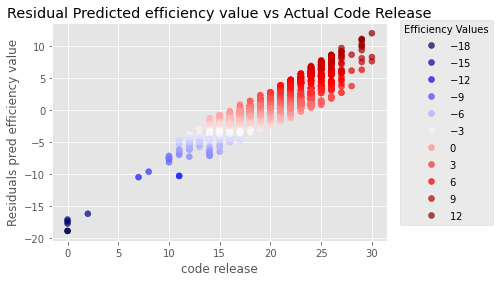

In [38]:
# plot efficiency value residual across code releases

x = resid_df['code_release_act']
y = resid_df['pred_resid']

# cmap['Diverging'] = [
#             'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
#             'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

c = resid_df['pred_resid']


fig, ax = plt.subplots()

scatter = ax.scatter(x, y, c=c, cmap='seismic', alpha=0.7)
# cbar = plt.colorbar()
# cbar.set_label('Efficiency Value')
ax.set_title('Residual Predicted efficiency value vs Actual Code Release')
ax.set_xlabel('code release')
ax.set_ylabel('Residuals pred efficiency value')

legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", bbox_to_anchor=(1.33, 0.05), title="Efficiency Values")

In [192]:
# wine_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data' 
# wine_column_headers = ['Alcohol','Malic acid','Ash','Alcalinity of ash',  
#                        'Magnesium','Total phenols','Flavanoids',
#                        'Nonflavanoid phenols','Proanthocyanins','Color intensity', 
#                        'Hue','OD280/OD315 of diluted wines' ,'Proline']
# wine_df = pd.read_csv(wine_url, names = wine_column_headers)
# wine_df.head()

When the actual code release is less than the predicted efficiency value then the residual is a negative value. This indicates that the building is less efficient than expected given the efficiency standards the year it was built. This indicates there may be an opportunity for energy efficiency professionals to have a bigger impact.

#### Create feature for efficiency improvement rollout groups 

In [39]:
resid_df.head()

,Unnamed: 0,avg_kwh,Latitude,Longitude,Heated_SquareFeet,kwh_per_sqft,code_release_act,code_release_pred,pred_resid
0,6410,1027.639344,29.705515,-82.364586,1516.0,0.677862,16,18.149881,-2.149881
1,4903,766.774510,29.612746,-82.371744,1172.0,0.654244,24,22.207415,1.792585
2,367,544.843137,29.611465,-82.360356,5944.0,0.091663,20,20.141803,-0.141803
3,2448,1026.689320,29.675848,-82.384052,1684.0,0.609673,20,18.125896,1.874104
4,4206,500.291262,29.635181,-82.343227,1120.0,0.446689,18,18.849894,-0.849894


In [40]:
preds_min_df = resid_df.sort_values(by=['pred_resid'], ascending=False)

In [41]:
preds_min_df = preds_min_df.reset_index(drop=True)

In [42]:
preds_min_df.head()

,Unnamed: 0,avg_kwh,Latitude,Longitude,Heated_SquareFeet,kwh_per_sqft,code_release_act,code_release_pred,pred_resid
0,1772,336.141414,29.655511,-82.303003,1032.0,0.325718,30,17.991768,12.008232
1,2664,781.207317,29.657335,-82.301698,1288.0,0.606527,29,17.866151,11.133849
2,7787,419.770000,29.654719,-82.303309,1647.0,0.254869,29,17.977489,11.022511
3,10658,726.708738,29.665694,-82.391749,2382.0,0.305083,29,18.101922,10.898078
4,9180,640.279070,29.636609,-82.335384,2064.0,0.310213,29,18.653999,10.346001


In [43]:
preds_min_df['phase'] = preds_min_df['pred_resid']
preds_min_df.head()

,Unnamed: 0,avg_kwh,Latitude,Longitude,Heated_SquareFeet,kwh_per_sqft,code_release_act,code_release_pred,pred_resid,phase
0,1772,336.141414,29.655511,-82.303003,1032.0,0.325718,30,17.991768,12.008232,12.008232
1,2664,781.207317,29.657335,-82.301698,1288.0,0.606527,29,17.866151,11.133849,11.133849
2,7787,419.770000,29.654719,-82.303309,1647.0,0.254869,29,17.977489,11.022511,11.022511
3,10658,726.708738,29.665694,-82.391749,2382.0,0.305083,29,18.101922,10.898078,10.898078
4,9180,640.279070,29.636609,-82.335384,2064.0,0.310213,29,18.653999,10.346001,10.346001


In [44]:
phase_df = preds_min_df[['phase']]

In [45]:
#8615
phase_num = len(preds_min_df)/4
phase_1 = phase_num
phase_2 = phase_num*2
phase_3 = phase_num*3
phase_4 = phase_num*4


phase_df.loc[0:phase_1, 'phase'] = 1
phase_df.loc[phase_1:phase_2, 'phase'] = 2
phase_df.loc[phase_2:phase_3, 'phase'] = 3
phase_df.loc[phase_3:phase_4, 'phase'] = 4


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [47]:
preds_min_df['phase'] = phase_df
preds_min_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5384 entries, 0 to 5383
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5384 non-null   int64  
 1   avg_kwh            5384 non-null   float64
 2   Latitude           5384 non-null   float64
 3   Longitude          5384 non-null   float64
 4   Heated_SquareFeet  5384 non-null   float64
 5   kwh_per_sqft       5384 non-null   float64
 6   code_release_act   5384 non-null   int64  
 7   code_release_pred  5384 non-null   float64
 8   pred_resid         5384 non-null   float64
 9   phase              5384 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 420.8 KB


In [201]:
# calculate avg kwh for each phase 
phase_1_avg = preds_min_df[preds_min_df['phase'] == 1]['avg_kwh'].agg('mean')
phase_2_avg = preds_min_df[preds_min_df['phase'] == 2]['avg_kwh'].agg('mean')
phase_3_avg = preds_min_df[preds_min_df['phase'] == 3]['avg_kwh'].agg('mean')
phase_4_avg = preds_min_df[preds_min_df['phase'] == 4]['avg_kwh'].agg('mean')
print(phase_1_avg, phase_2_avg, phase_3_avg, phase_4_avg)

3212.1891155807666 3302.7971164640726 3182.907276495421 4011.506785622089


#### Add dates for phases

In [290]:
# # Create a dataframe with index length of my prediction 
# date_df.index = pd.to_datetime(date_df.index, infer_datetime_format=True)
# index = pd.date_range(start='2020-01-31', end='2022-01-31', freq='M')
# columns = ['phase']
# future_kwh_full = pd.DataFrame(index=index, columns=columns)

In [272]:
future_kwh_full.head()

,phase
2020-01-31,NaN
2020-02-29,NaN
2020-03-31,NaN
2020-04-30,NaN
2020-05-31,NaN


#### Export for efficiency phase rollout simulation in Dash

In [266]:
# export efficiency improvement rollout df for use in Carbon zero simulation
preds_min_df.to_csv(r'stationary-data/preds_min_df.csv', header=True)

In [267]:
preds_min_df.head()

,Parcel Number,avg_kwh,Heated_SquareFeet,kwh_per_sqft,code_release_pred,code_release,pred_resid,phase
0,9024003000,205.030303,2440.0,0.084029,16.387264,30,13.612736,1.0
1,9971001000,386.581395,8158.0,0.047387,15.940885,29,13.059115,1.0
2,10606014000,1032.479592,1260.0,0.819428,17.441719,30,12.558281,1.0
3,11105000000,336.141414,1032.0,0.325718,17.583820,30,12.416180,1.0
4,11686014000,579.281553,908.0,0.637975,16.778669,29,12.221331,1.0


<h4>What is the distribution of efficiency values for an given address over time?</h4>

In [214]:
#  electricity_df[200:400]

In [212]:
# add_1 = electricity_df[electricity_df['Service Address'] == '8574 SW 26TH LN']
# add_2 = electricity_df[electricity_df['Service Address'] == '8901 SW 67TH PL']
# add_3 = electricity_df[electricity_df['Service Address'] == '916 NW 6TH AVE']

In [213]:
# add_1 = add_1.sort_values(by=['Date'])
# add_2 = add_2.sort_values(by=['Date'])
# add_3 = add_3.sort_values(by=['Date'])

In [211]:
# # plot efficiency values for 8574 SW 26TH LN

# x = add_1['Date']
# y = add_1['preds']*100

# # plot energy consumption at same address 
# x2 = add_2['Date']
# y2 = add_2['KWH Consumption']

# # x3 = add_3['Date']
# # y3 = add_3['preds']


# fig, ax = plt.subplots(figsize=(20,5))
# ax.plot(x3, y3)
# ax.plot(x2, y2)
# ax.plot(x, y)
# ax.set_title('Efficiency Values for 8574 SW 26TH LN and 8901 SW 67TH PL')
# ax.set_xlabel('Date (2012 - 2020)')
# ax.set_ylabel('Efficiency Value')
# plt.xticks()
# plt.legend(loc=0)

In [210]:
# add_3.describe()

In [209]:
# add_2.describe()

In [208]:
# add_1.describe()

In [206]:
# add_2.head()

In [207]:
# # plot efficiency values for a single address

# x2 = add_2['Date']
# y2 = add_2['preds']

# fig, ax = plt.subplots(figsize=(20,10))

# ax.plot(x2, y2)
# ax.set_title('Efficiency Values for 8901 SW 67TH PL')
# ax.set_xlabel('Date (2012 - 2020)')
# ax.set_ylabel('Efficiency Value')